In this experiment, we decode Shor's nine-qubit quantum error correcting code. Here, we demonstrate error-based correction, which means that the decoder takes a Pauli error as input and outputs the most likely logical operator. After one run of the algorithm we will end up with a probability distribution over I, X, Z, Y Pauli operators.

In [26]:
import numpy as np
import qecstruct as qc
import qecsim.paulitools as pt
import matplotlib.pyplot as plt
from tqdm import tqdm

from mdopt.mps.utils import marginalise, create_custom_product_state
from mdopt.contractor.contractor import mps_mpo_contract
from mdopt.optimiser.utils import (
    SWAP,
    COPY_LEFT,
    XOR_BULK,
    XOR_LEFT,
    XOR_RIGHT,
)
from examples.decoding.decoding import (
    css_code_checks,
    css_code_logicals,
    css_code_logicals_sites,
    css_code_constraint_sites,
)
from examples.decoding.decoding import (
    apply_constraints,
    apply_bias_channel,
)

Let us first import the code from `qecstruct` and take a look at it.

In [27]:
code = qc.shor_code()
code

X stabilizers:
[0, 1, 2, 3, 4, 5]
[3, 4, 5, 6, 7, 8]
Z stabilizers:
[0, 1]
[1, 2]
[3, 4]
[4, 5]
[6, 7]
[7, 8]

This quantum error correcting code is defined on 9 physical qubits and has 2 logical operators. This means we will need $9*2 + 2 = 20$ sites in our MPS.

In [28]:
num_logicals = code.num_x_logicals() + code.num_z_logicals()
num_sites = 2 * len(code) + num_logicals
assert num_sites == 20
assert num_logicals == 2

Now, let us define the initial state. First of all we will check that no error implies no correction. This means starting from the all-zeros state followed by decoding will return all-zeros state for the logical operators (the final logical operator will thus be identity operator).

In [29]:
error_state = "0" * (num_sites - num_logicals)
logicals_state = "+" * num_logicals
state_string = logicals_state + error_state
error_mps = create_custom_product_state(string=state_string)

Here, we get the sites where the checks will be applied. We will need to construct MPOs using this data.

In [30]:
checks_x, checks_z = css_code_checks(code)
print("X checks:")
for check in checks_x:
    print(check)
print("Z checks:")
for check in checks_z:
    print(check)

X checks:
[2, 4, 6, 8, 10, 12]
[8, 10, 12, 14, 16, 18]
Z checks:
[3, 5]
[5, 7]
[9, 11]
[11, 13]
[15, 17]
[17, 19]


These lists mention only the sites where we will apply the XOR constraints. However, the MPOs will also consist of other tensors, such as SWAPs (tensors' legs crossings) and boundary XOR constraints. In what follows we define the list of these auxiliary tensors and the corresponding sites where they reside.

In [31]:
constraints_tensors = [XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT]
logicals_tensors = [COPY_LEFT, XOR_BULK, SWAP, XOR_RIGHT]

In [32]:
constraints_sites = css_code_constraint_sites(code)
print("Full X-check lists of sites:")
for string in constraints_sites[0]:
    print(string)
print("Full Z-check lists of sites:")
for string in constraints_sites[1]:
    print(string)

Full X-check lists of sites:
[[2], [4, 6, 8, 10], [3, 5, 7, 9, 11], [12]]
[[8], [10, 12, 14, 16], [9, 11, 13, 15, 17], [18]]
Full Z-check lists of sites:
[[3], [], [4], [5]]
[[5], [], [6], [7]]
[[9], [], [10], [11]]
[[11], [], [12], [13]]
[[15], [], [16], [17]]
[[17], [], [18], [19]]


Let us now take a look at the logical operators.

In [33]:
print(code.x_logicals_binary())
print(code.z_logicals_binary())

[0, 1, 2]

[0, 3, 6]



We need to again translate it to our MPO language by changing the indices since we add the logical-operator sites to the end of the MPS.

In [34]:
print(css_code_logicals(code)[0])
print(css_code_logicals(code)[1])

[2, 4, 6]
[3, 9, 15]


Now goes the same operation of adding sites where auxiliary tensors should be placed.

In [35]:
logicals_sites = css_code_logicals_sites(code)
print(css_code_logicals_sites(code)[0])
print(css_code_logicals_sites(code)[1])

[[0], [2, 4], [1, 3, 5], [6]]
[[1], [3, 9], [2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14], [15]]


Now the fun part, MPS-MPO contraction. But first, we apply the bias channel to our error state. This is done to bias our output towards the received input. This is done by distributing the amplitude around the initial basis product state to other basis product states in the descending order by Hamming distance.

In [36]:
renormalise = True
error_mps = apply_bias_channel(
    basis_mps=error_mps, basis_string=state_string, prob_channel=0.1
)

In [37]:
error_mps = apply_constraints(
    error_mps,
    constraints_sites[0],
    constraints_tensors,
    renormalise=renormalise,
)
error_mps = apply_constraints(
    error_mps,
    constraints_sites[1],
    constraints_tensors,
    renormalise=renormalise,
)
error_mps = apply_constraints(
    error_mps,
    logicals_sites,
    logicals_tensors,
    renormalise=renormalise,
)

100%|██████████| 2/2 [00:00<00:00, 272.60it/s]


Now, we marginalise over the message bits to get the logical operator MPS.

In [38]:
sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
logical = marginalise(mps=error_mps, sites_to_marginalise=sites_to_marginalise).dense(flatten=True, renormalise=True)
print(logical)

[0.89935243 0.09956401 0.4231521  0.04684562]


Which indeed tells us that most likely we do not need to apply any operator!

Let's now put all of this into a function. We'll need this to run the decoder over a bunch of single- and multiqubit errors.

In [39]:
def decode_shor(error : str, renormalise: bool = True, silent: bool = True):
    """
    This function does error-based decoding of Shor's code. 
    It takes as input an error string and returns the most likely Pauli correction.

    Parameters
    ----------
    error : str
        The error in a string format.
        The way the decoder takes the error is as follows:
        "X_0 Z_0 X_1 Z_1 ..."
    renormalise : bool
        Whether to renormalise the spectra during contraction.
    silent : bool
        Whether to show the progress bars or not.

    Raises
    ------
    ValueError
        If the error string length does not correspond to the code.
    """

    code = qc.shor_code()
    num_sites = 2 * len(code) + code.num_x_logicals() + code.num_z_logicals()
    num_logicals = code.num_x_logicals() + code.num_z_logicals()
    assert num_sites == 20
    assert num_logicals == 2

    if len(error) != num_sites - num_logicals:
        raise ValueError(f"The error length is {len(error)}, expected {num_sites - num_logicals}.")

    logicals_state = "+" * num_logicals
    state_string = logicals_state + error
    error_mps = create_custom_product_state(string=state_string)
    constraints_tensors = [XOR_LEFT, XOR_BULK, SWAP, XOR_RIGHT]
    logicals_tensors = [COPY_LEFT, XOR_BULK, SWAP, XOR_RIGHT]
    constraints_sites = css_code_constraint_sites(code)
    logicals_sites = css_code_logicals_sites(code)

    error_mps = apply_bias_channel(
        basis_mps=error_mps, basis_string=state_string, prob_channel=0.1
    )

    error_mps = apply_constraints(
        error_mps,
        constraints_sites[0],
        constraints_tensors,
        renormalise=renormalise,
        silent=silent,
    )
    error_mps = apply_constraints(
        error_mps,
        constraints_sites[1],
        constraints_tensors,
        renormalise=renormalise,
        silent=silent,
    )
    error_mps = apply_constraints(
        error_mps,
        logicals_sites,
        logicals_tensors,
        renormalise=renormalise,
        silent=silent,
    )

    sites_to_marginalise = list(range(num_logicals, len(error_state) + num_logicals))
    logical = marginalise(mps=error_mps, sites_to_marginalise=sites_to_marginalise).dense(flatten=True, renormalise=True)
    logical /= np.linalg.norm(logical)

    if np.argmax(logical) == 0:
        return "I"
    if np.argmax(logical) == 1:
        return "X"
    if np.argmax(logical) == 2:
        return "Z"
    if np.argmax(logical) == 3:
        return "Y"

Let's now generate all possible one-, two- and three-qubit errors using `qecsim`.

In [40]:
one_qubit_paulis = pt.ipauli(n_qubits=len(code), min_weight=1, max_weight=1)
two_qubit_paulis = pt.ipauli(n_qubits=len(code), min_weight=2, max_weight=2)
three_qubit_paulis = pt.ipauli(n_qubits=len(code), min_weight=3, max_weight=3)

In [41]:
def pauli_to_mps(pauli_string):
    mps_string = ""
    for pauli in pauli_string:
        if pauli == "I":
            mps_string += "00"
        elif pauli == "X":
            mps_string += "10"
        elif pauli == "Y":
            mps_string += "11"
        elif pauli == "Z":
            mps_string += "01"
        else:
            raise ValueError(f"Invalid Pauli encountered -- {pauli}.")

    return mps_string

In [42]:
one_qubit_errors = [pauli_to_mps(pauli) for pauli in one_qubit_paulis]
one_qubit_corrections = [decode_shor(error) for error in tqdm(one_qubit_errors)]

100%|██████████| 27/27 [00:00<00:00, 103.90it/s]


In [43]:
two_qubit_errors = [pauli_to_mps(pauli) for pauli in two_qubit_paulis]
two_qubit_corrections = [decode_shor(error) for error in tqdm(two_qubit_errors)]

100%|██████████| 324/324 [00:03<00:00, 102.85it/s]


In [44]:
three_qubit_errors = [pauli_to_mps(pauli) for pauli in three_qubit_paulis]
three_qubit_corrections = [decode_shor(error) for error in tqdm(three_qubit_errors)]

100%|██████████| 2268/2268 [00:21<00:00, 104.19it/s]


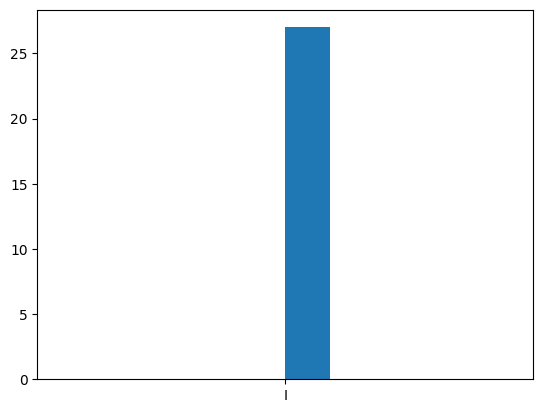

In [45]:
plt.hist(one_qubit_corrections)
plt.show()

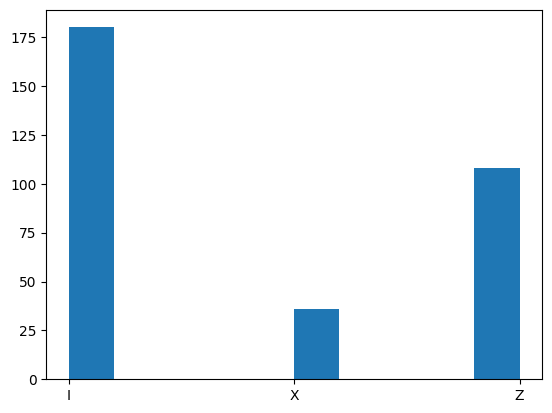

In [46]:
plt.hist(two_qubit_corrections)
plt.show()

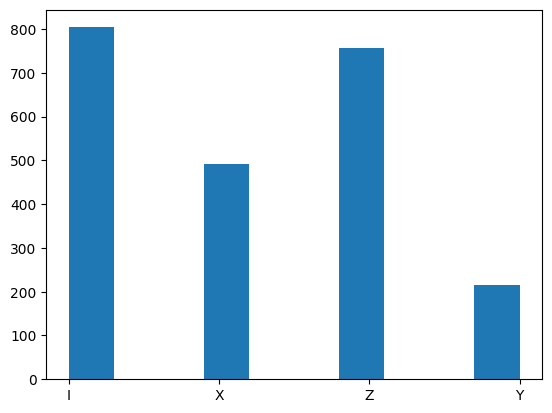

In [47]:
plt.hist(three_qubit_corrections)
plt.show()

In [48]:
one_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=1, max_weight=1))
two_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=2, max_weight=2))
three_qubit_paulis = list(pt.ipauli(n_qubits=len(code), min_weight=3, max_weight=3))

In [49]:
for i, correction in enumerate(two_qubit_corrections):
    if correction=="I":
        print(
            two_qubit_paulis[i]
            )

XXIIIIIII
XZIIIIIII
XYIIIIIII
ZXIIIIIII
YXIIIIIII
XIXIIIIII
XIZIIIIII
XIYIIIIII
ZIXIIIIII
YIXIIIIII
XIIZIIIII
ZIIXIIIII
ZIIZIIIII
ZIIYIIIII
YIIZIIIII
XIIIZIIII
ZIIIXIIII
ZIIIZIIII
ZIIIYIIII
YIIIZIIII
XIIIIZIII
ZIIIIXIII
ZIIIIZIII
ZIIIIYIII
YIIIIZIII
XIIIIIZII
ZIIIIIXII
ZIIIIIZII
ZIIIIIYII
YIIIIIZII
XIIIIIIZI
ZIIIIIIXI
ZIIIIIIZI
ZIIIIIIYI
YIIIIIIZI
XIIIIIIIZ
ZIIIIIIIX
ZIIIIIIIZ
ZIIIIIIIY
YIIIIIIIZ
IXXIIIIII
IXZIIIIII
IXYIIIIII
IZXIIIIII
IYXIIIIII
IXIZIIIII
IZIXIIIII
IZIZIIIII
IZIYIIIII
IYIZIIIII
IXIIZIIII
IZIIXIIII
IZIIZIIII
IZIIYIIII
IYIIZIIII
IXIIIZIII
IZIIIXIII
IZIIIZIII
IZIIIYIII
IYIIIZIII
IXIIIIZII
IZIIIIXII
IZIIIIZII
IZIIIIYII
IYIIIIZII
IXIIIIIZI
IZIIIIIXI
IZIIIIIZI
IZIIIIIYI
IYIIIIIZI
IXIIIIIIZ
IZIIIIIIX
IZIIIIIIZ
IZIIIIIIY
IYIIIIIIZ
IIXZIIIII
IIZXIIIII
IIZZIIIII
IIZYIIIII
IIYZIIIII
IIXIZIIII
IIZIXIIII
IIZIZIIII
IIZIYIIII
IIYIZIIII
IIXIIZIII
IIZIIXIII
IIZIIZIII
IIZIIYIII
IIYIIZIII
IIXIIIZII
IIZIIIXII
IIZIIIZII
IIZIIIYII
IIYIIIZII
IIXIIIIZI
IIZIIIIXI
IIZIIIIZI
IIZIIIIYI
IIYIIIIZI


In [50]:
for i, correction in enumerate(three_qubit_corrections):
    if correction=="I":
        print(
            three_qubit_paulis[i]
            )

XXXIIIIII
XXZIIIIII
XXYIIIIII
XZXIIIIII
XYXIIIIII
ZXXIIIIII
YXXIIIIII
XXIXIIIII
XXIZIIIII
XXIYIIIII
XZIZIIIII
XYIXIIIII
XYIZIIIII
XYIYIIIII
ZXIZIIIII
YXIXIIIII
YXIZIIIII
YXIYIIIII
XXIIXIIII
XXIIZIIII
XXIIYIIII
XZIIZIIII
XYIIXIIII
XYIIZIIII
XYIIYIIII
ZXIIZIIII
YXIIXIIII
YXIIZIIII
YXIIYIIII
XXIIIXIII
XXIIIZIII
XXIIIYIII
XZIIIZIII
XYIIIXIII
XYIIIZIII
XYIIIYIII
ZXIIIZIII
YXIIIXIII
YXIIIZIII
YXIIIYIII
XXIIIIXII
XXIIIIZII
XXIIIIYII
XZIIIIZII
XYIIIIXII
XYIIIIZII
XYIIIIYII
ZXIIIIZII
YXIIIIXII
YXIIIIZII
YXIIIIYII
XXIIIIIXI
XXIIIIIZI
XXIIIIIYI
XZIIIIIZI
XYIIIIIXI
XYIIIIIZI
XYIIIIIYI
ZXIIIIIZI
YXIIIIIXI
YXIIIIIZI
YXIIIIIYI
XXIIIIIIX
XXIIIIIIZ
XXIIIIIIY
XZIIIIIIZ
XYIIIIIIX
XYIIIIIIZ
XYIIIIIIY
ZXIIIIIIZ
YXIIIIIIX
YXIIIIIIZ
YXIIIIIIY
XIXXIIIII
XIXZIIIII
XIXYIIIII
XIZZIIIII
XIYXIIIII
XIYZIIIII
XIYYIIIII
ZIXZIIIII
YIXXIIIII
YIXZIIIII
YIXYIIIII
XIXIXIIII
XIXIZIIII
XIXIYIIII
XIZIZIIII
XIYIXIIII
XIYIZIIII
XIYIYIIII
ZIXIZIIII
YIXIXIIII
YIXIZIIII
YIXIYIIII
XIXIIXIII
XIXIIZIII
XIXIIYIII
XIZIIZIII
XIYIIXIII
